# ACB - Music classification

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.preprocessing import StandardScaler,MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold

%matplotlib inline

Show the versions of the modules used for the project:

In [2]:
print(f"{np.__name__} version = {np.__version__}")
print(f"{pd.__name__} version = {pd.__version__}")
print(f"{sklearn.__name__} version = {sklearn.__version__}")
print(f"{mpl.__name__} version = {mpl.__version__}")
print(f"{sns.__name__} version = {sns.__version__}")

numpy version = 1.24.2
pandas version = 1.5.3
sklearn version = 1.2.1
matplotlib version = 3.7.0
seaborn version = 0.12.2


In [3]:
SEED = 123
SAVE = True
np.random.default_rng(seed=SEED)

Generator(PCG64) at 0x7FB535E929E0

Set the plotting style to `fivethirtyeight` just cause

In [4]:
plot_style = "fivethirtyeight"

plt.style.use(style=plot_style)
sns.set_palette("Paired")

## Reading the data and quick exploratory data analysis

In [5]:
df_raw = pd.read_csv("../data/dados.csv")
df_raw.shape

(999, 199)

In [6]:
df_raw.head()

,filename,tempo,chroma_stft_mean,chroma_stft_var,chroma_stft_max,chroma_stft_min,chroma_stft_median,chroma_stft_qt1,chroma_stft_qt2,rms_mean_mean,...,mfcc_mean_18_qt1,mfcc_mean_18_qt2,mfcc_mean_19_mean,mfcc_mean_19_var,mfcc_mean_19_max,mfcc_mean_19_min,mfcc_mean_19_median,mfcc_mean_19_qt1,mfcc_mean_19_qt2,label
0,blues.00000.wav,123.046875,0.350129,0.088772,1.0,0.001883,0.254469,0.112016,0.509971,0.130184,...,-7.189630,1.837867,1.222467,46.941350,32.866340,-23.219631,0.941804,-3.579244,5.497650,blues
1,blues.00001.wav,107.666016,0.340849,0.094976,1.0,0.001808,0.232328,0.089450,0.521089,0.095908,...,-4.961407,4.222943,0.530644,45.788700,27.740532,-17.131062,0.290101,-4.288013,4.693344,blues
2,blues.00002.wav,161.499023,0.363538,0.085257,1.0,0.003168,0.275098,0.130408,0.520045,0.175473,...,-8.082528,0.335357,-2.238128,30.653150,16.524359,-29.785423,-2.112655,-5.789953,1.266118,blues
3,blues.00003.wav,172.265625,0.404854,0.093999,1.0,0.005738,0.320005,0.145432,0.622788,0.141040,...,-4.728713,3.534681,-3.405046,31.965254,16.595015,-21.426252,-3.723261,-6.868982,-0.029808,blues
4,blues.00004.wav,135.999178,0.308526,0.087843,1.0,0.001347,0.201387,0.084953,0.429789,0.091501,...,-9.217802,0.448059,-11.704385,55.190254,4.889852,-41.730530,-10.748793,-15.777891,-6.449556,blues


In [7]:
df_raw.tail()

,filename,tempo,chroma_stft_mean,chroma_stft_var,chroma_stft_max,chroma_stft_min,chroma_stft_median,chroma_stft_qt1,chroma_stft_qt2,rms_mean_mean,...,mfcc_mean_18_qt1,mfcc_mean_18_qt2,mfcc_mean_19_mean,mfcc_mean_19_var,mfcc_mean_19_max,mfcc_mean_19_min,mfcc_mean_19_median,mfcc_mean_19_qt1,mfcc_mean_19_qt2,label
994,rock.00095.wav,103.359375,0.351977,0.080479,1.0,0.005424,0.263867,0.130719,0.486072,0.079446,...,-10.667875,-2.157617,-1.198403,49.946903,21.106043,-22.082030,-0.870149,-5.877096,3.354293,rock
995,rock.00096.wav,117.453835,0.398869,0.075117,1.0,0.015388,0.323889,0.184963,0.541574,0.076423,...,-11.642376,-3.169349,-2.791855,31.719294,14.861097,-19.902115,-3.008246,-6.528909,0.997393,rock
996,rock.00097.wav,129.199219,0.431980,0.075221,1.0,0.006835,0.370889,0.216633,0.591718,0.081598,...,-17.128510,-8.109871,-2.104325,29.860994,16.930466,-21.867311,-1.863467,-5.494790,1.414281,rock
997,rock.00098.wav,112.347147,0.362635,0.091532,1.0,0.000592,0.274618,0.110386,0.549156,0.083802,...,-9.732834,-0.612432,-3.587599,41.296356,20.287260,-22.774874,-3.836333,-7.861920,0.380314,rock
998,rock.00099.wav,123.046875,0.358318,0.085817,1.0,0.004010,0.262763,0.128006,0.515196,0.054431,...,-7.819255,3.772562,1.150108,49.735140,29.696540,-21.608265,0.684592,-3.657846,4.877181,rock


In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Columns: 199 entries, filename to label
dtypes: float64(197), object(2)
memory usage: 1.5+ MB


In [9]:
def convert_numeric(df):
    df = df.copy()
    df[df.select_dtypes("number").columns] = df.select_dtypes("number").astype(np.float32)
    return df
    
def convert_category(df):
    df = df.copy()
    df["label"] = df["label"].astype("category")
    return df


In [10]:
df = (
    df_raw
    .pipe(convert_numeric)
    .pipe(convert_category)
    .drop(["filename"], axis = 1)
    .rename(columns = {"label":"genre"})
    .sample(frac = 1, random_state = SEED)
    .reset_index(drop = True)
)

In [11]:
df.head()

,tempo,chroma_stft_mean,chroma_stft_var,chroma_stft_max,chroma_stft_min,chroma_stft_median,chroma_stft_qt1,chroma_stft_qt2,rms_mean_mean,rms_mean_var,...,mfcc_mean_18_qt1,mfcc_mean_18_qt2,mfcc_mean_19_mean,mfcc_mean_19_var,mfcc_mean_19_max,mfcc_mean_19_min,mfcc_mean_19_median,mfcc_mean_19_qt1,mfcc_mean_19_qt2,genre
0,112.347145,0.303251,0.089593,1.0,0.001021,0.192122,0.072654,0.431641,0.026787,0.000342,...,-7.092338,4.157803,-3.818604,88.638634,37.769127,-29.682255,-5.023259,-9.993509,1.511925,classical
1,161.499023,0.376988,0.083790,1.0,0.003654,0.283156,0.150821,0.535613,0.204271,0.001920,...,-5.752795,2.507965,-3.078908,51.755867,16.769207,-24.104900,-3.161209,-7.775723,1.794894,country
2,135.999176,0.401009,0.089657,1.0,0.002326,0.331715,0.145864,0.598354,0.182285,0.003976,...,-7.306152,1.171250,0.705028,55.644600,23.745577,-22.897854,0.639649,-4.493629,5.592843,blues
3,161.499023,0.325428,0.087600,1.0,0.001496,0.224143,0.095076,0.459756,0.071379,0.000794,...,-5.306351,4.497449,6.321081,100.530167,35.653419,-19.270657,6.225543,-0.877847,12.986521,jazz
4,112.347145,0.294611,0.088108,1.0,0.002020,0.185114,0.071379,0.403091,0.044323,0.001092,...,-9.735260,3.697661,-3.284700,97.682816,31.533157,-24.643005,-4.996558,-10.412316,1.571471,classical


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Columns: 198 entries, tempo to genre
dtypes: category(1), float32(197)
memory usage: 770.2 KB


In [13]:
print(f"Number of missing values in the dataset is {df.isnull().sum().sum()}")

Number of missing values in the dataset is 0


Since the number of missing values there's no need to check each column to see how they're distributed

## Quick plot to check to see each variable distribuition and the correlation between each other

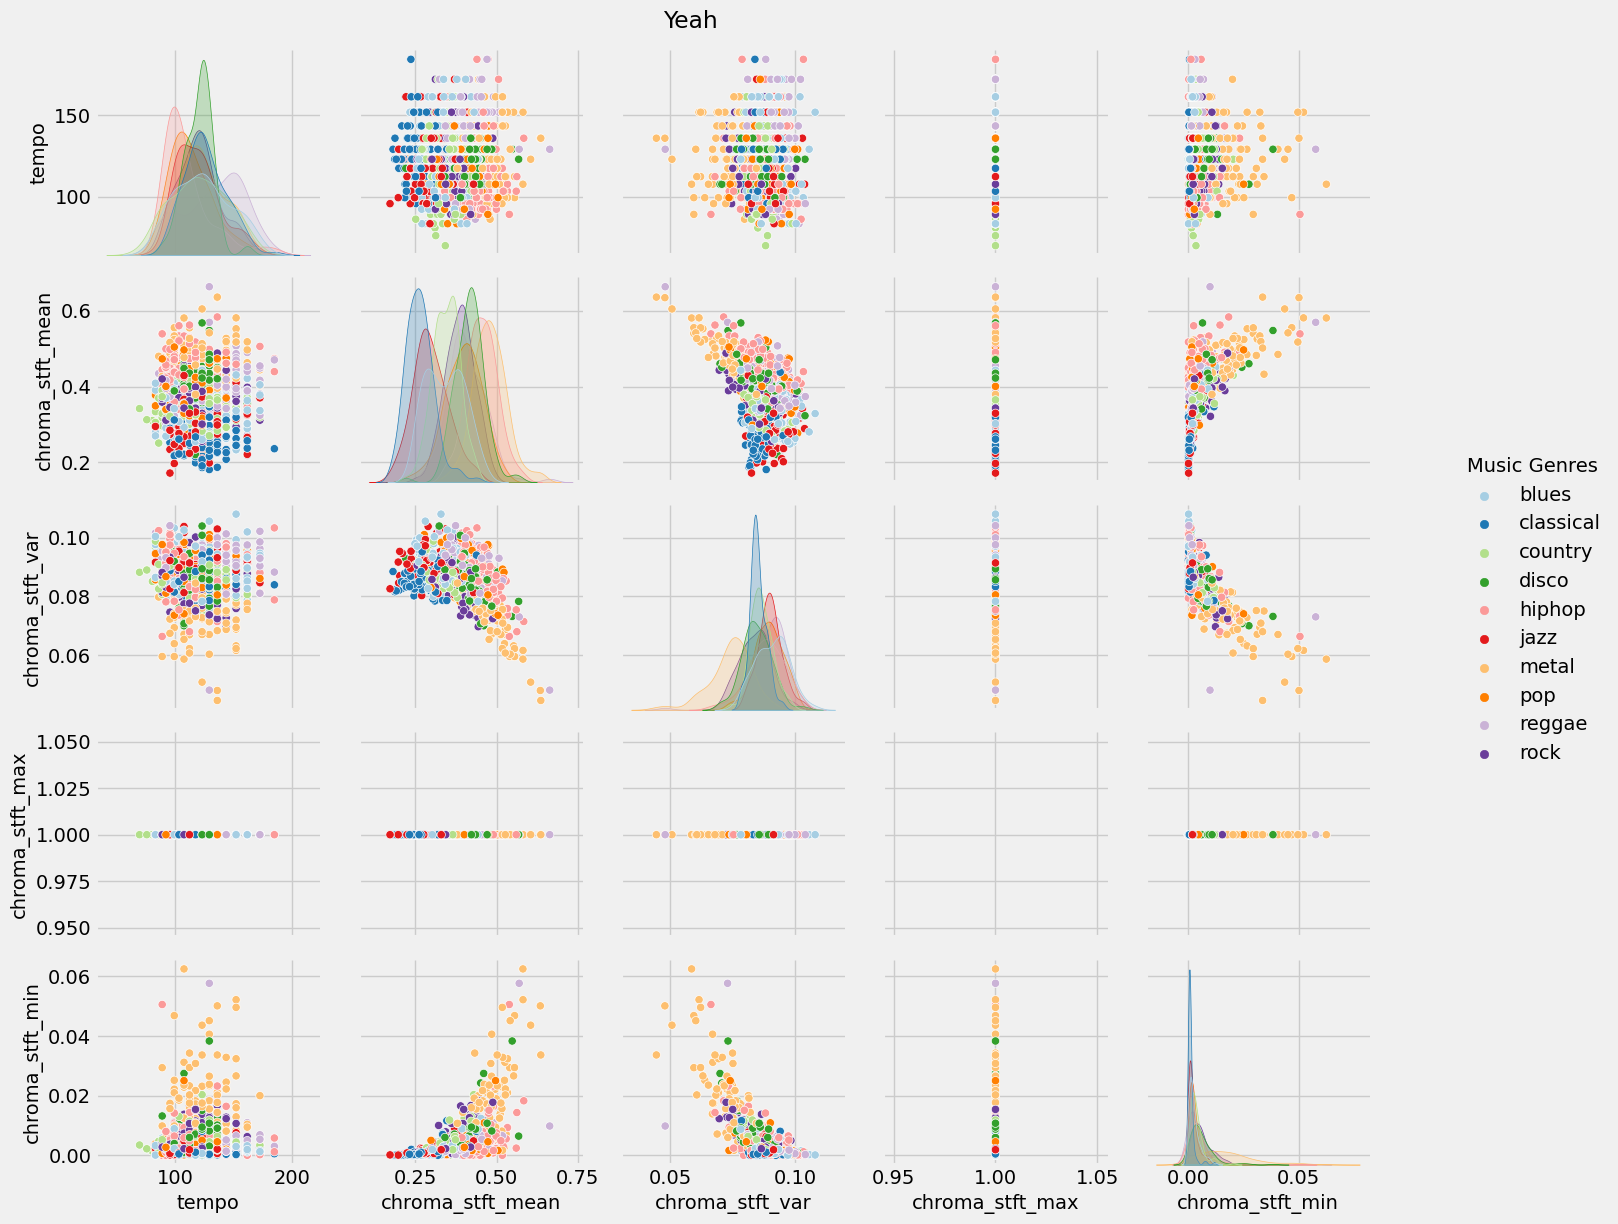

In [14]:
ax = sns.pairplot(df, diag_kind="kde", vars = df.columns[:5], hue = "genre")
ax._legend.set_title("Music Genres")
sns.move_legend(ax, bbox_to_anchor=(1.04, 0.5), loc="center left", fancybox=True, shadow=True )
plt.suptitle("Yeah")
plt.tight_layout()
if SAVE:
    plt.savefig("../images/yeah.png", format = "png")
plt.show()

## See the distribution of the target variable, the music genre

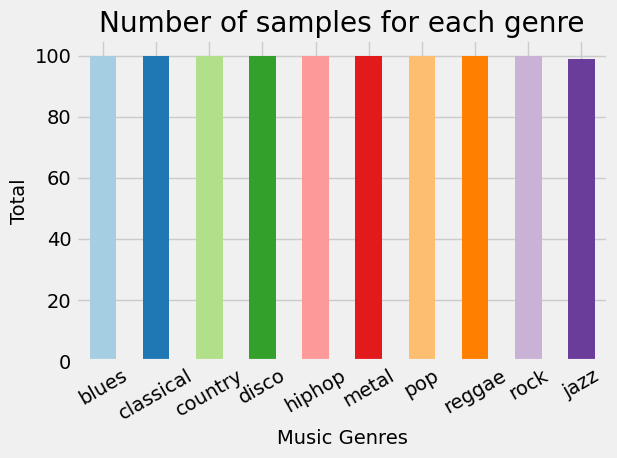

In [15]:
n = df["genre"].nunique()
colors = [f"C{x}" for x in range(n)]
df["genre"].value_counts().plot(kind = "bar", rot = 30, color = colors, stacked = True)

plt.title("Number of samples for each genre")
plt.xlabel("Music Genres")
plt.ylabel("Total")
plt.tight_layout()
if SAVE:
    plt.savefig("../images/classes_distribution.png", format = "png")
plt.show()

With our data cleaned up and with some quick vizualization of our variables we can proceed to the next step.

## Feature selection/Feature reduction

Here we split the dataframe into our features and the target variables.
We also extract the features names with the goal to be able the interpret the feature selection algorithms results.

In [16]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

input_features = df.columns[:-1]

### Encoding the target variable

This is done before the data split for convenience since there's no risk of data leaking

In [17]:
le = LabelEncoder()
y = le.fit_transform(y)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = SEED, test_size = .2)

### Removing Outliers from our data

Since models can be negatively affected by the presence of outliers by introducing a certain bias to the models predictions, we think it's important to remove them.
This is only done to the training data to prevent data leak to the test data.

There's a lot of methods to remove outliers from the dataset but since we have a relatively high number of features we chose one already available from the `scikit-learn` module the `Local Outlier Factor`

-> Describe algorithm

In [19]:
lof = LocalOutlierFactor()
yhet = lof.fit_predict(X_train)
mask = yhet != -1

In [20]:
X_train,y_train = X_train[mask,:], y_train[mask]

### Setting up a pipeline to perform the feature selection / reduction

We think that for this step it is preferable to proceed this way for $2$ reasons:
- It's easy to perform the same processing methods used on the training data to the untouched test data.
- It's also easy to add a model to the last step of the pipeline to have a quick and easy way to perform *p.e.* cross validation.

In our pipeline we defined the following steps:
-  Scaled the data with Standard scaling method.
- Checked for low variance features with a threshold of $\frac{1}{4}$.
- Selected the best $20$ features according to the p-values of an ANOVA statistical test (arbitrary number).

In [21]:
pipeline_steps = [
    ("scaler", StandardScaler()),
    ("variance_threshold", VarianceThreshold(threshold=.25)),
    ("k_best", SelectKBest(score_func=f_classif, k = 10)),
]
pipeline = Pipeline(steps=pipeline_steps)

In [22]:
X_train = pipeline.fit_transform(X_train,y_train)
X_test = pipeline.transform(X_test)

In [23]:
X_train.shape, X_test.shape

((769, 10), (200, 10))

### Interpret the feature selection / reduction performed

Here we can check which features remained from the pipeline steps

In [24]:
variance_mask = pipeline["variance_threshold"].get_support()
input_features = input_features[variance_mask]

In [25]:
k_best_mask = pipeline["k_best"].get_support()
kbest_features = input_features[k_best_mask]
scores = pipeline["k_best"].scores_[k_best_mask]

In [26]:
score_sorting = np.argsort(scores)[::-1]
y_pos = np.arange(1, len(scores) + 1)
kbest_features = kbest_features.str.replace("stft_", "").str.replace("_max", "").str.replace("mean_0_", "")

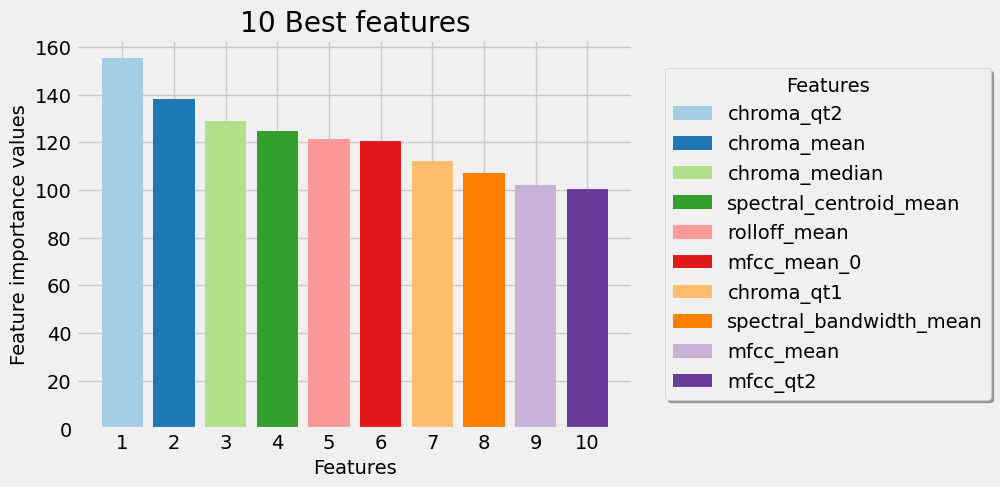

In [27]:
ax = plt.subplot()
ax.bar(y_pos, scores[score_sorting], color = colors, label = kbest_features[score_sorting])
ax.set(
    title="10 Best features",
     xticks=y_pos,
     ylabel="Feature importance values",
    xlabel="Features"
)
plt.legend(title = "Features", bbox_to_anchor=(1.04, 0.5), loc="center left", fancybox=True, shadow=True)
if SAVE:
    plt.savefig("../images/best_k_features.png", format = "png")
plt.show()

In [28]:
# # só temos um valor unico para toda esta coluna, não nos está a fornecer qualquer tipo de informaçao
# df_raw.chroma_stft_max.nunique()
# # como apareceu só um unico valor para a "chroma_stft_max" vamos verificar para todos os colunas com max no nome
# cols_with_max = df_raw.columns[df_raw.columns.str.contains("max")]
# # chroma_stft_max é a unica com 1 valor unico por isso é só essa que temos de retirar do dataset 
# df_raw[cols_with_max].nunique()
# df.plot(
#     kind = "hist",
#     subplots = True,
#     layout = (-1,4),
#     figsize = (20, 300), 
#     legend = False,
#     sharey = True)
# plt.show()
# scaler = StandardScaler()
# X = scaler.fit_transform(X, y)
# X = pd.DataFrame(X, columns=col_names)
# corr_table = X.corr().abs()
# upper = corr_table.where(np.triu(np.ones(corr_table.shape), k=1).astype(bool))
# to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
# len(to_drop)
# sns.pairplot(corr_table, diag_kind="kde", vars = to_drop[:7])
# plt.show()
# X = X.drop(to_drop, axis=1)
# X.shape
# col_names = X.columns
# vt = VarianceThreshold(threshold=(.8 * (1 - .8)))
# X = vt.fit_transform(X,y)
# X = pd.DataFrame(X, columns=col_names)
# X.plot(
#     kind = "hist",
#     bins = 100,
#     subplots = True,
#     layout = (-1,4),
#     figsize = (10, 50), 
#     legend = False,
#     sharey = True,
#     # title=X.columns.to_list()
# )
# plt.tight_layout()
# plt.show()
# selector = SelectKBest(score_func=f_classif, k = 20)
# X = selector.fit_transform(X, y)
# score_dict = {name:score for name, score in zip(selector.get_feature_names_out(), selector.scores_)}
# score_dicted = {k: v for k, v in sorted(score_dict.items(), key=lambda x : x[1], reverse = True)}
# score_dicted
# arg_sorted = np.argsort(selector.scores_)
# # plt.bar([*range(len(selector.scores_))], selector.scores_)
# # plt.xticks([*range(len(selector.scores_))], selector.get_feature_names_out())